In [31]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

**Задача.** На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

**Решение:** <br>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_excel('/content/drive/MyDrive/AB_Test_Results.xlsx')
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


**Первичный анализ данных**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
df.USER_ID.nunique() # количество уникальных значений

6324

In [8]:
df.isna().sum() # проверим наличие значений NaN в DataFrame

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [9]:
df.groupby('VARIANT_NAME')['USER_ID'].count().reset_index() # проверим разбивку пользователей по группам при проведение a/b тестирования

,VARIANT_NAME,USER_ID
0,control,4984
1,variant,5016


**Вывод:** Как видно количество пользователей которые видят старую и новую версию сайта разбиты примерно поровну 5016 к 4984

Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [10]:
a = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})
a

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


In [11]:
df_new = df.drop_duplicates(subset='USER_ID')
df_new

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9988,428,control,0.0
9991,8864,variant,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [14]:
df.shape[0], df_new.shape[0], df.shape[0]-df_new.shape[0] #  количество записей:(в исходном наборе, в очищенном от дубликатов наборе, удаленных из датасета записей)

(10000, 6324, 3676)

Разделим данные на неочищенные (первоначальные) - raw и очищенные данные - unic для дальнейшего анализа

In [17]:
raw_control = df.query('VARIANT_NAME == "control"') # raw - неочищенные данные
raw_variant = df.query('VARIANT_NAME == "variant"') # raw - неочищенные данные
unic_control = df_new.query('VARIANT_NAME == "control"') # unic - очищенные данные
unic_variant = df_new.query('VARIANT_NAME == "variant"') # unic - очищенные данные


Объем выборки для неочищенных данных - row

In [18]:
len(raw_control), len(raw_variant)

(4984, 5016)

Объем выборки для очищенных данных - unic

In [19]:
len(unic_control), len(unic_variant)

(3132, 3192)

Для проверки нормальности используем критерий Шапиро-Уилка.

In [21]:
alpha = 0.05
st = shapiro(df.REVENUE)
print('Распределение raw {}нормальное\n'.format( {True:'не ',
False:''}[st[1] < alpha]))
st = shapiro(df_new.REVENUE)
print('Распределение unic {}нормальное\n'.format( {True:'не ',
False:''}[st[1] < alpha]))

Распределение raw не нормальное

Распределение unic не нормальное



**Вывод:** Подтвердили предположение о ненормальности данных

Построим гистограмму распределения выручки между группами control и variant в наборе - raw

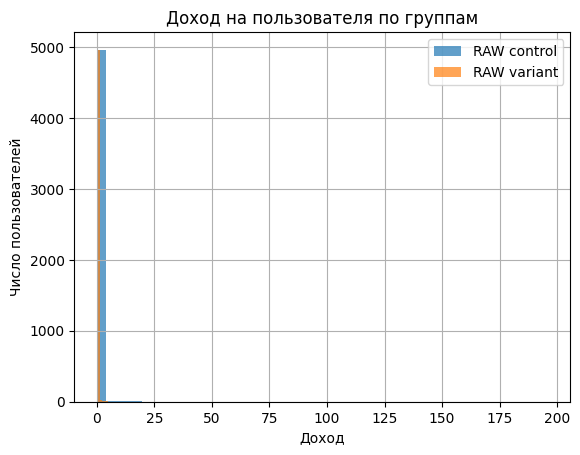

In [22]:
raw_control.REVENUE.hist(bins = 50, alpha =0.7, label='RAW control')
raw_variant.REVENUE.hist(bins = 50, alpha =0.7, label='RAW variant')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Построим гистограмму распределения выручки между группами control и variant в наборе - unic

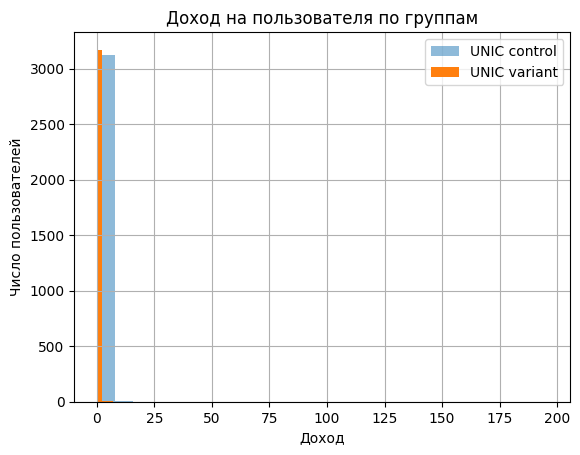

In [23]:
unic_control.REVENUE.hist(bins = 25, alpha =0.5, label='UNIC control')
unic_variant.REVENUE.hist(bins = 25, alpha =1, label='UNIC variant')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Построим boxplot для всех наборов данных: raw и unic

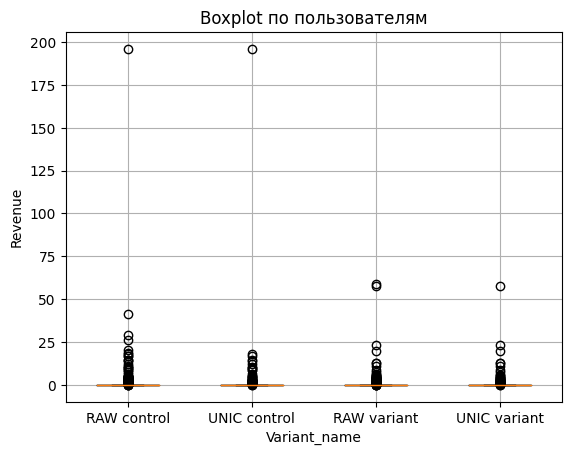

In [24]:
plt.boxplot([raw_control.REVENUE, unic_control.REVENUE, raw_variant.REVENUE, unic_variant.REVENUE],
            labels=['RAW control', 'UNIC control', 'RAW variant', 'UNIC variant'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.xlabel('Variant_name')
plt.ylabel('Revenue')
plt.grid(axis  ='both')

**Вывод:** Как видно из графиков особой разницы между распределением в исходном наборе данных raw и в очищенном наборе unic нет. В обоих наборах данных много выбросов

Определим есть ли статистически значимая разница в наборах raw и unic, используем критерий Манна-Уитни.

In [51]:
alpha = 0.05
mw1 = mannwhitneyu(x=raw_control.REVENUE.values,
                  y=raw_variant.REVENUE.values)
mw1

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

In [52]:
alpha = 0.05
mw2 = mannwhitneyu(x=unic_control.REVENUE.values,
                  y=unic_variant.REVENUE.values)
mw2


MannwhitneyuResult(statistic=5006376.5, pvalue=0.6049438033840282)

**Вывод:** в результате расчета статистической разницы между наборами данных,используя метод расчета критерия Манна-Уитни, получили следующие результаты: p-value больше уровня значимости  α=0.05, следовательно, статистически значимой разницы в наборах данных raw и unic нет.

Выполним двухвыборочную t-проверку с помощью функции ttest_ind

In [53]:
ttest_ind(raw_control.REVENUE.values, raw_variant.REVENUE.values, equal_var = False)

TtestResult(statistic=1.268403803110966, pvalue=0.20469713432410777, df=6811.174610031575)

In [54]:
ttest_ind(unic_control.REVENUE.values, unic_variant.REVENUE.values, equal_var = False)

TtestResult(statistic=0.8007101375053801, pvalue=0.4233485464256115, df=3876.177170021392)

**Вывод:** в результате двухвыборочной t - проверки с помощью функции ttest_ind, p-value больше уровня значимости  α=0.05, а следовательно, статистически значимой разницы в наборах данных raw и unic нет.




Определим достаточна ли была мощность выборок, чтобы анализировать результаты, используя следующие формулы:<br>
d = (M1 – M2) / S_pooled<br>
S_pooled = sqrt( (std1^2 + std2^2) /2 )


Расчет мощности для первоначальных данных - raw

In [58]:
raw_control_mean = raw_control.REVENUE.values.mean()
raw_variant_mean = raw_variant.REVENUE.values.mean()
raw_control_std = raw_control.REVENUE.values.std()
raw_variant_std = raw_variant.REVENUE.values.std()
raw_Spooled = np.sqrt((raw_control_std**2 + raw_variant_std **2)/ 2)
raw_effect=float((raw_control_mean - raw_variant_mean) / raw_Spooled)
raw_n=len(raw_control.REVENUE)

alpha = 0.05
analysis = TTestIndPower()
raw_power_result = analysis.solve_power(raw_effect, power=None, nobs1=raw_n, ratio=1.0, alpha=alpha)
raw_effect, raw_power_result

(0.025398300337756648, 0.24502831099016653)

Расчет мощности для очищенных данных - unic

In [59]:
unic_control_mean = unic_control.REVENUE.values.mean()
unic_variant_mean = unic_variant.REVENUE.values.mean()
unic_control_std = unic_control.REVENUE.values.std()
unic_variant_std = unic_variant.REVENUE.values.std()
unic_Spooled = np.sqrt((unic_control_std**2 + unic_variant_std **2)/ 2)
unic_effect=float((unic_control_mean - unic_variant_mean) / unic_Spooled)
unic_n=len(unic_control.REVENUE)

alpha = 0.05
analysis = TTestIndPower()
unic_power_result = analysis.solve_power(unic_effect, power=None, nobs1=unic_n, ratio=1.0, alpha=alpha)
unic_effect, unic_power_result

(0.020216294110608147, 0.12590090022749384)

**Вывод:** Мощности тестов составили: для исходного набора данных raw - 24.5% и для очищенного набора unic - 13%, что является достаточно низким значением и таким образом для принятия решения по вопросу: какой тест control или variant обеспечивает наибольшую выручку, не хватает данных.<br>

**Рекомендации:**
1. A/B тест следует откатить назад.
2. Рассчитать требуемый размер выборки и избегать преждевременной остановки теста.
2. Увеличить длительность теста и запустить его заново.